# Using  Hierarchical  and K means Clustering to analyse the olympics history


In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

/home/nimisha/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/nimisha/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
data = pd.read_csv('dataSource/athlete_events.csv')
print(data.shape)

(271116, 15)


## Data Preprocessing - Missing Value Treatment by the imputation method


In [3]:
## The data has 9474 null values in Age , hence will be substituting with the mean

AgeMean = int(data['Age'].mean())
print('Age Mean', AgeMean)
data['Age'] = data['Age'].fillna(AgeMean)
data['Age'].isna().sum()

## 22% of the Height and 23% of the Weight column is having NaN values
## The NaN values are substitued with mode


HeightMode = data['Height'].mode()[0] ## 0 -> the column wise mode 
print('Height Mode',HeightMode)
data['Height'] = data['Height'].fillna(HeightMode)
data['Height'].isna().sum()


WeightMode = data['Weight'].mode()[0]
print('Weight Mode',WeightMode)
data['Weight'] = data['Weight'].fillna(WeightMode)
data['Weight'].isna().sum()

##The Medal column has NaN values if no medal is won , we Substitute the NaN values with a string 'None'

data['Medal'] = data['Medal'].fillna('None')
data['Medal'].isna().sum()



Age Mean 25
Height Mode 180.0
Weight Mode 70.0


0

# Merging Multiple DataSets

In [4]:
noc_country = pd.read_csv("dataSource/noc_regions.csv")
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

noc_country.head()


#Merging the datasets

olympics_merge = data.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

# Do we have NOCs that didnt have a matching country in the master?
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()
olympics_merge.shape

## Merge gdp

w_gdp = pd.read_csv('dataSource/world_gdp.csv', skiprows = 3)

# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()


# Replace missing Teams by the values above.
olympics_merge.loc[olympics_merge['Country'].isnull(), ['Country']] = olympics_merge['Team']

olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

# Merge to get country code
olympics_merge_ccode = olympics_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

### Merge Population Data

# Read in the population data
w_pop = pd.read_csv('dataSource/world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None,China,CHN,4.269160e+11,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None,China,CHN,8.560550e+12,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,180.0,70.0,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None,Denmark,DNK,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,180.0,70.0,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None,Netherlands,NLD,2.585680e+11,1.476009e+07


# Medals Won by Each Country

In [5]:

olympics_complete['Medal_Won'] = np.where(olympics_complete.loc[:,'Medal'] == 'None', 0, 1)
medalC = olympics_complete.groupby(['Team'])['Medal_Won'].agg('sum').reset_index()
medal_count_per_country = medalC.sort_values('Medal_Won',ascending = False)
#medal_count_per_country = medal_count_per_country.iloc[:136,:]
medal_count_per_country

,Team,Medal_Won
194,USA,5637
152,Russia,3947
67,Germany,3756
193,UK,2068
63,France,1777
87,Italy,1637
178,Sweden,1536
33,Canada,1352
10,Australia,1349
78,Hungary,1135


## GDP for the Year 2016

In [6]:
### GDP
###### TYG = 'Team,Year,GDP'
TYG = olympics_complete[olympics_complete['Year'] == 2016 ][['Team','Year','GDP']]

gdp = {}

for index,row in TYG.iterrows():
    if TYG.loc[index,'Team'] not in gdp:
        gdp[TYG.loc[index,'Team']] = TYG.loc[index,'GDP']

medal_count_per_country['GDP'] = medal_count_per_country['Team'].map(gdp)
medal_count_per_country['GDP'] = medal_count_per_country['GDP'].fillna(1)

### Population
###### TYP = 'Team,Year,Population'
TYP = olympics_complete[olympics_complete['Year'] == 2016][['Team','Year','Population']]

popu = {}

for index,row in TYP.iterrows():
    if TYP.loc[index,'Team'] not in popu:
        popu[TYP.loc[index,'Team']] = TYP.loc[index,'Population']


medal_count_per_country['Population'] = medal_count_per_country['Team'].map(popu)
medal_count_per_country['Population'] = medal_count_per_country['Population'].fillna(1)


## This is done to remove all the instances with missing or negligible population or GDP inorder to futher normalise the data 
medal_count_per_country = medal_count_per_country[medal_count_per_country['Population']>10000]

In [7]:
medal_count_per_country['Medal_WonNorm'] = (medal_count_per_country['Medal_Won']-medal_count_per_country['Medal_Won'].mean())/np.std(medal_count_per_country['Medal_Won'],axis = 0)
medal_count_per_country['GDPNorm'] = (medal_count_per_country['GDP']-medal_count_per_country['GDP'].mean())/np.std(medal_count_per_country['GDP'],axis = 0)
medal_count_per_country['PopulationNorm'] = (medal_count_per_country['Population']-medal_count_per_country['Population'].mean())/np.std(medal_count_per_country['Population'],axis = 0)

topMedalHolders = medal_count_per_country
topMedalHolders

/home/nimisha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/nimisha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/nimisha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,Team,Medal_Won,GDP,Population,Medal_WonNorm,GDPNorm,PopulationNorm
194,USA,5637,1.862450e+13,3.231275e+08,8.573176,11.260487,2.047279
152,Russia,3947,1.283160e+12,1.443424e+08,5.908533,0.562366,0.767728
67,Germany,3756,3.477800e+12,8.266768e+07,5.607381,1.916271,0.326327
193,UK,2068,2.647900e+12,6.563724e+07,2.945892,1.404293,0.204441
63,France,1777,2.465450e+12,6.689611e+07,2.487069,1.291737,0.213451
87,Italy,1637,1.858910e+12,6.060059e+07,2.266329,0.917554,0.168394
178,Sweden,1536,5.144600e+11,9.903122e+06,2.107081,0.088144,-0.194444
33,Canada,1352,1.529760e+12,3.628642e+07,1.816966,0.714497,-0.005620
10,Australia,1349,1.204620e+12,2.412716e+07,1.812236,0.513913,-0.092643
78,Hungary,1135,1.258170e+11,9.817958e+06,1.474820,-0.151616,-0.195053


In [8]:
topMedalHolders.columns



Index(['Team', 'Medal_Won', 'GDP', 'Population', 'Medal_WonNorm', 'GDPNorm',
       'PopulationNorm'],
      dtype='object')

# on Medal_Won vs GDP

# K Means Clustering

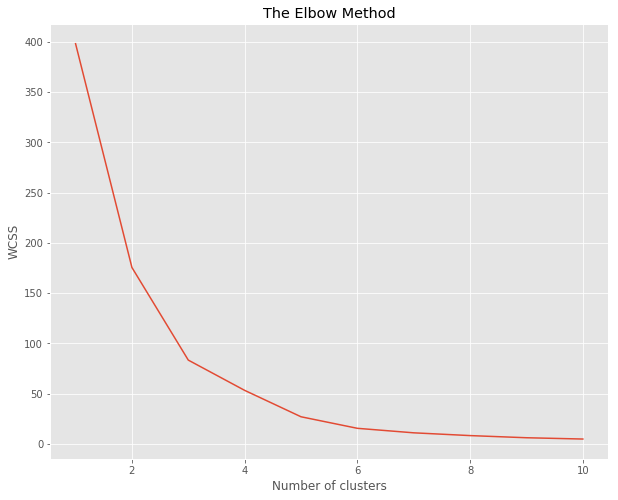

/home/nimisha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


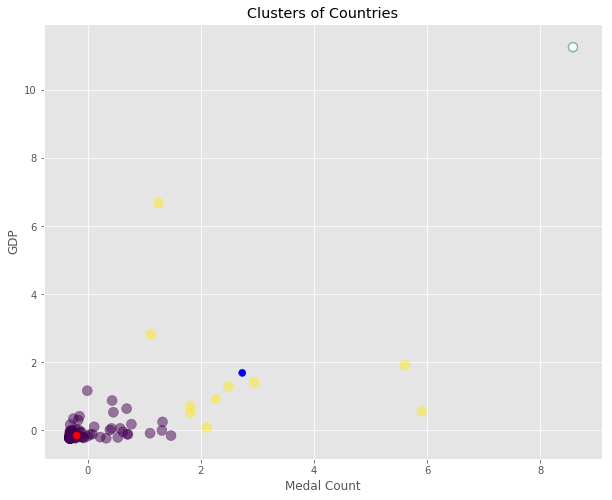

In [9]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(topMedalHolders.iloc[:, [4, 5]].values)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.figure(figsize=(10, 8))

# Fitting K-Means to the dataset
from mpl_toolkits.mplot3d import Axes3D

kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(topMedalHolders[['Medal_WonNorm','GDPNorm']])

centroids = kmeans.cluster_centers_

#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
topMedalHolders['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(topMedalHolders.groupby('cluster').mean(),1))
kmeans_mean_cluster

plt.title('Clusters of Countries')
plt.xlabel('Medal Count')
plt.ylabel('GDP')
plt.scatter( topMedalHolders['Medal_WonNorm'],topMedalHolders['GDPNorm'],s = 100,c= kmeans.labels_.astype(float), alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1],s= 50, c=['red','white','blue'])
plt.show()



# Hierarchical Clustering

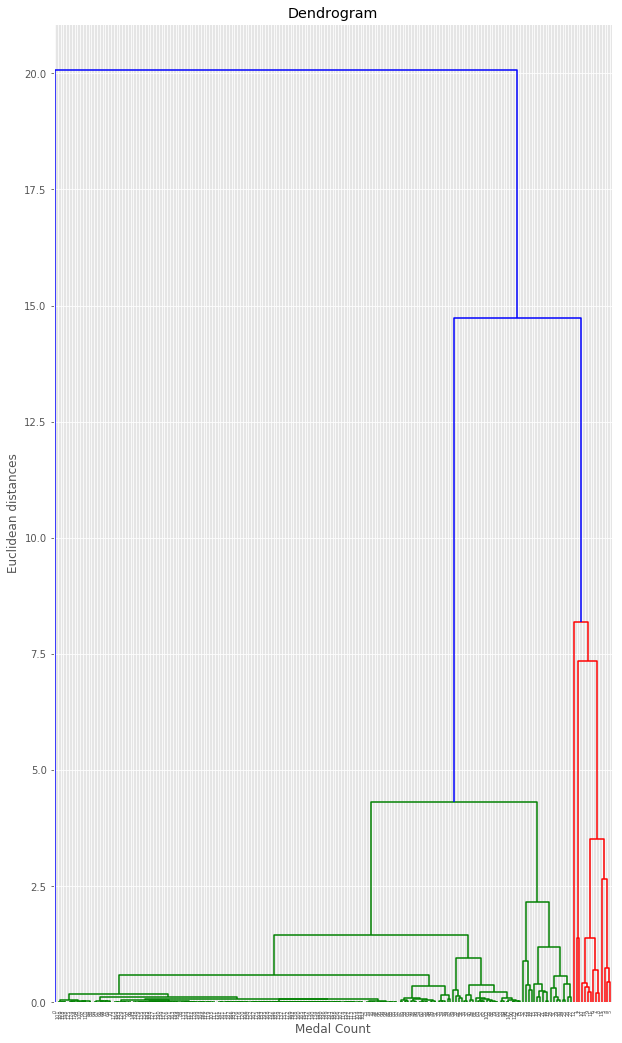

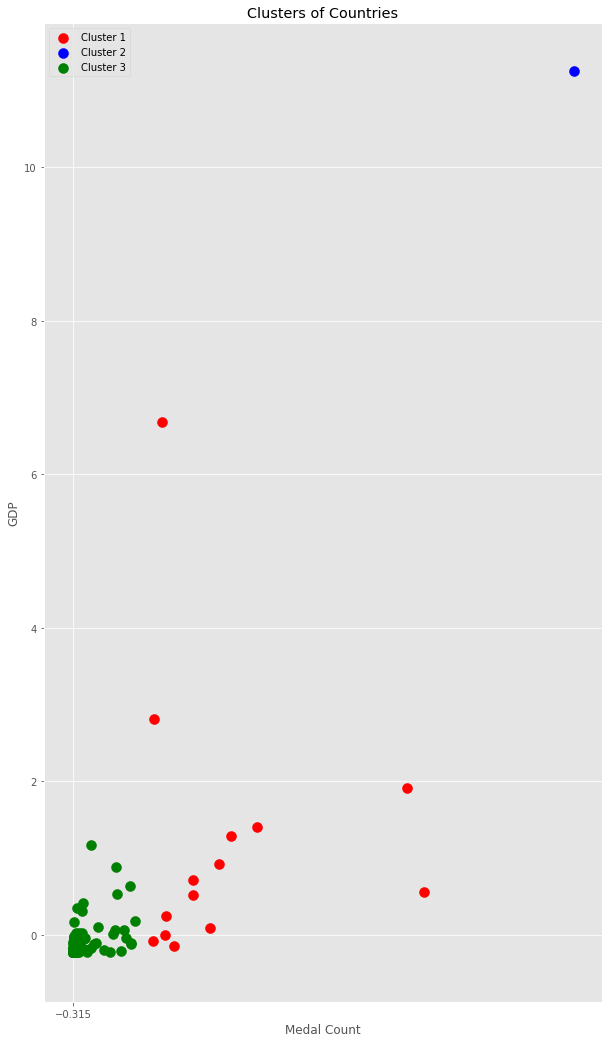

In [10]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
X = topMedalHolders.iloc[:, [4, 5]].values
#print(X)
# y = dataset.iloc[:, 3].values
plt.figure(figsize=(10,18))

# Using the dendrogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Medal Count')
plt.ylabel('Euclidean distances')
plt.show()

# Fitting Hierarchical Clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)


# Visualising the clusters
plt.figure(figsize=(10,18))
plt.xticks(np.arange(min(topMedalHolders['Medal_WonNorm']), max(topMedalHolders['Medal_WonNorm']), 800)) 
#plt.xticks(np.arange(min(topMedalHolders['GDP']), max(topMedalHolders['GDP']),1.084733e+05)) 
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
#plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'Black', label = 'USA')
#plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.title('Clusters of Countries')
plt.xlabel('Medal Count')
plt.ylabel('GDP')
plt.legend()
plt.show()

# Results on no_of_medals_won vs GDP:
### On comparing the results of the K-Means clustering and Hierachial clustering to divide of the instances into clusters, both the results seem to follow almost similar distribution.
### Using the result of the elbow method of k-means clustering, 3 was found to be the appropriate no of clusters. Hence, for both the k-means and hierarchial clustering I chose 3 as the ideal no of clusters for better analysis.
### The clusters formed are as follows:
     1. Green Cluster: with very few medals and less GDP.
     2. Red Cluster: with average range  of no of medals and average distributed GDP
     3. Blue Cluster: the highest no of medals and highest GDP     

# on Medal_Won vs Population

# K Means Clustering

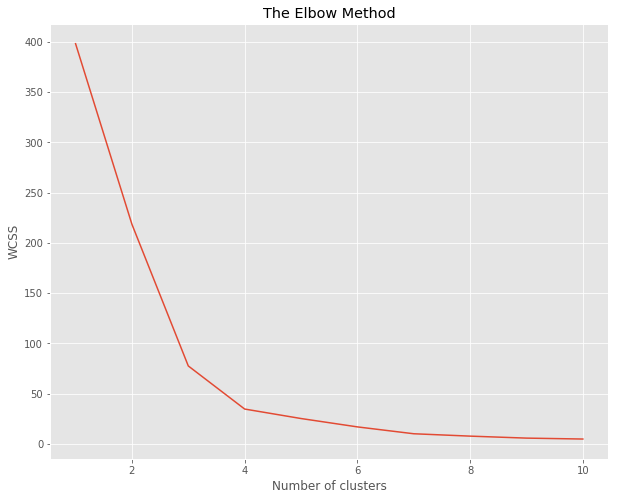

/home/nimisha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


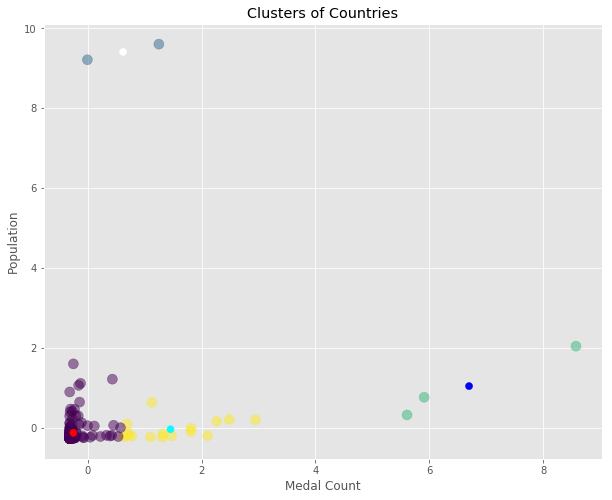

In [11]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(topMedalHolders.iloc[:, [4, 6]].values)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.figure(figsize=(10, 8))

# Fitting K-Means to the dataset
from mpl_toolkits.mplot3d import Axes3D

kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(topMedalHolders[['Medal_WonNorm','PopulationNorm']])

centroids = kmeans.cluster_centers_

#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
topMedalHolders['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(topMedalHolders.groupby('cluster').mean(),1))
kmeans_mean_cluster

plt.title('Clusters of Countries')
plt.xlabel('Medal Count')
plt.ylabel('Population')
plt.scatter( topMedalHolders['Medal_WonNorm'],topMedalHolders['PopulationNorm'],s = 100,c= kmeans.labels_.astype(float), alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1],s = 50, c=['red','white','blue','cyan'])
plt.show()





# Hierarchial Clustering 

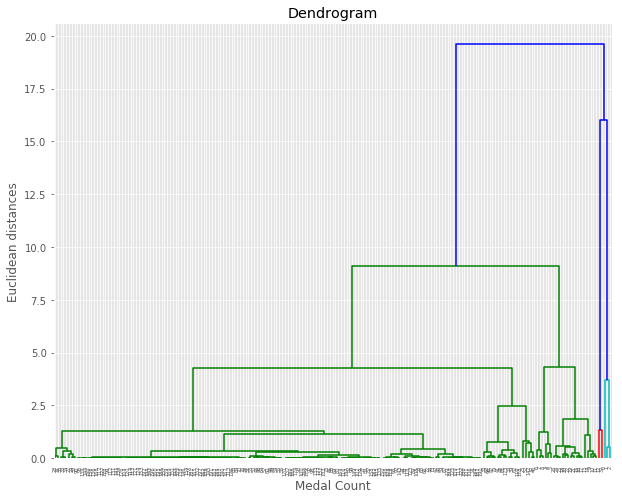

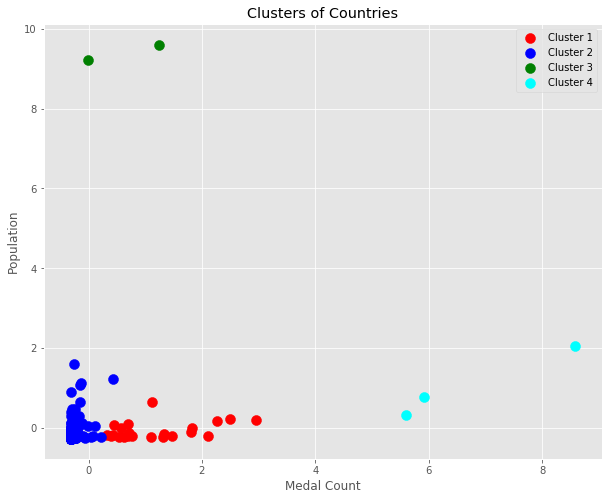

In [12]:
# Importing the libraries
'''import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
'''
# Importing the dataset
X = topMedalHolders.iloc[:, [4, 6]].values
# y = dataset.iloc[:, 3].values
plt.figure(figsize=(10, 8))

# Using the dendrogram to find the optimal number of clusters
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Medal Count')
plt.ylabel('Euclidean distances')
plt.show()

# Fitting Hierarchical Clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)


# Visualising the clusters
plt.figure(figsize=(10, 8))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')
#plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Cluster 5')
plt.title('Clusters of Countries')
plt.xlabel('Medal Count')
plt.ylabel('Population')
plt.legend()
plt.show()

# Results on no_of_medals_won vs Population:
### On comparing the results of the K-Means clustering and Hierachial clustering to divide of the instances into clusters, both the results seem to follow almost similar distribution.
### Using the result of the elbow method of k-means clustering,  4 was found to be the appropriate no of clusters. Hence, for both the k-means and hierarchial clustering I chose 4 as the ideal no of clusters for better analysis.
### The clusters formed are as follows:
     1. Blue Cluster: with very few medals and very less Population.
     2. Red Cluster: with relatively higher no of medals when compared to 'Blue' Cluster,(average no of medals) but less Population
     3. Cyan Cluster: with many medals and relatively less population.
     4. Green Cluster: with relatively fewer medal but very large popuation
     

# $$ $$




# KMeans Clustering to see the distribution of Height and Weight of players

# Standardize the data to normal distribution


In [13]:
data['HeightNorm'] = (data['Height']-data['Height'].mean())/np.std(data['Height'],axis = 0)
data['WeightNorm'] = (data['Weight']-data['Weight'].mean())/np.std(data['Weight'],axis = 0)


In [14]:
## Input for K Means Algo
### Creating dataset for the winners alone
med = ['Gold','Silver','Bronze']
Height_Weight_Win = data[data.Medal.isin(med)]
Height_Weight_Win = Height_Weight_Win[['HeightNorm','WeightNorm']]

### Creating dataset for all the players  
Height_Weight= data[['HeightNorm','WeightNorm']]

Height_Weight.head()

,HeightNorm,WeightNorm
0,0.382626,0.752137
1,-0.672438,-0.837921
2,0.382626,-0.042892
3,0.382626,-0.042892
4,0.910158,0.911143


# Find the appropriate cluster number


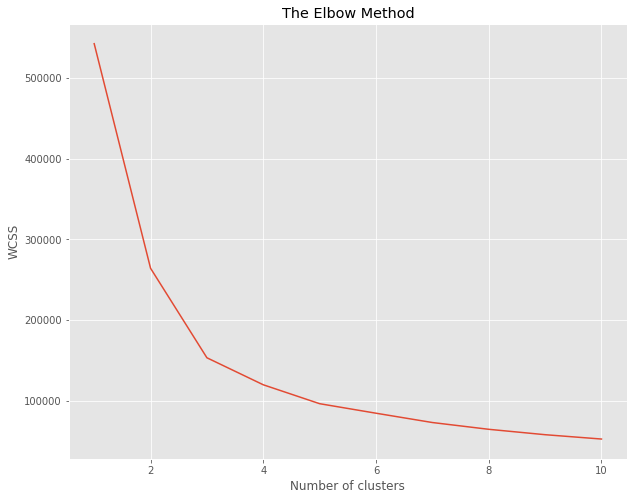

/home/nimisha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


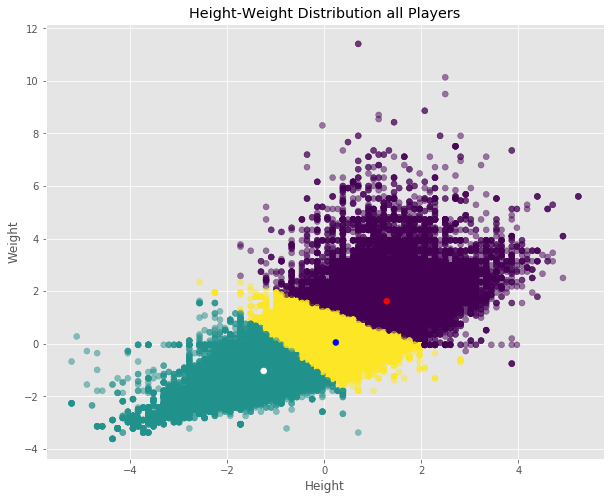

In [15]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Height_Weight)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.figure(figsize=(10, 8))

# Fitting K-Means to the dataset
from mpl_toolkits.mplot3d import Axes3D

kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(Height_Weight)

centroids = kmeans.cluster_centers_

#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
Height_Weight['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(Height_Weight.groupby('cluster').mean(),1))
kmeans_mean_cluster

plt.title('Height-Weight Distribution all Players')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.scatter(Height_Weight['HeightNorm'], Height_Weight['WeightNorm'], c= kmeans.labels_.astype(float), alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c=['red','white','blue'])


plt.show()


## Winning Medals

In [16]:
Height_Weight_Win = Height_Weight_Win[['HeightNorm','WeightNorm']]

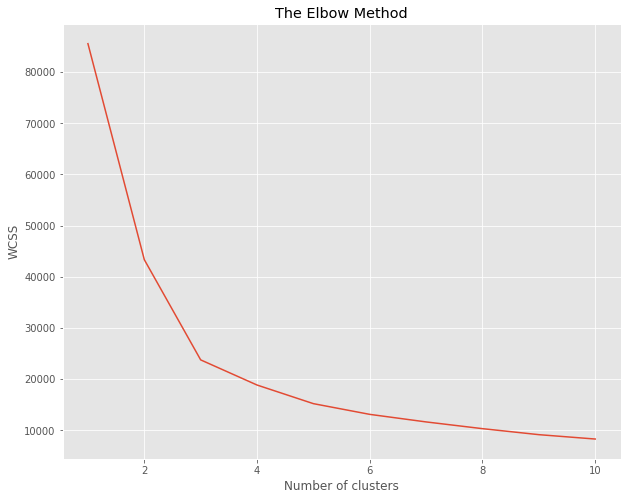

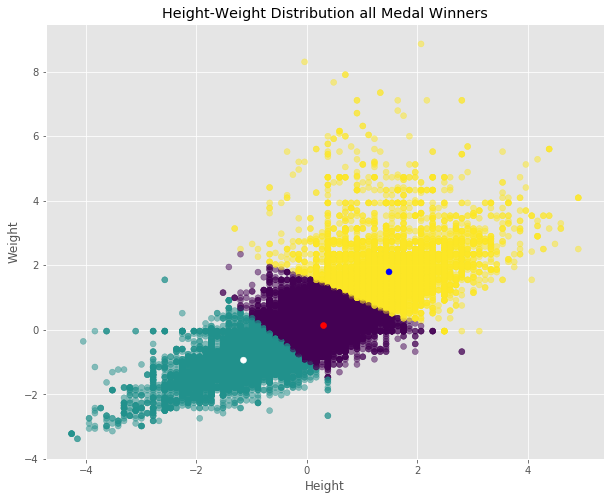

In [17]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(Height_Weight_Win)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fitting K-Means to the dataset
from mpl_toolkits.mplot3d import Axes3D
plt.figure(figsize=(10, 8))

kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(Height_Weight_Win)

centroids = kmeans.cluster_centers_

#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
Height_Weight_Win['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(Height_Weight_Win.groupby('cluster').mean(),1))
kmeans_mean_cluster

plt.title('Height-Weight Distribution all Medal Winners')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.scatter(Height_Weight_Win['HeightNorm'], Height_Weight_Win['WeightNorm'], c= kmeans.labels_.astype(float), alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c=['red','white','blue'])
plt.show()



#  $$ $$ 
# Conclusion

## The results of the K Means clustering i.e. the height weight distribution:
    a) For all the Players
    b) For all Medalists

### Both of them follow a similar distribution, and hence the winners and non-winners do not show a huge  difference in their height and weight. This shows that, taking the height and weight into considerence, all the players have almost equally likely chances to win a medal.